In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
chunksize=100000
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

In [3]:
# Custom date parser function
date_parser = lambda x: pd.to_datetime(x, unit='s')

# tags
tags = pd.DataFrame()  # initialize an empty dataframe
for index, chunk in enumerate(pd.read_csv('../ml-20m/tags.csv',
                         dtype={'userId': str, 'movieId': str, "tag": str, 'timestamp': int},
                         chunksize=chunksize,
                         parse_dates=['timestamp'],
                         date_parser=date_parser
                         )):
    # Perform operations on the chunk
    # processed_chunk = chunk[chunk['column_name'] > 0]  # Example operation
    tags = pd.concat([tags, chunk])
    print(f"Chunk {index} loaded")
print("Ratings dataset loaded")

/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_92694/1220741014.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  for index, chunk in enumerate(pd.read_csv('../ml-20m/tags.csv',


Chunk 0 loaded
Chunk 1 loaded
Chunk 2 loaded
Chunk 3 loaded
Chunk 4 loaded
Ratings dataset loaded


In [6]:
def clean_text(text):
    if pd.isna(text):
        return ''
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply the cleaning function to the 'tag' column
tags['cleaned_tag'] = tags['tag'].apply(clean_text)

# Display the first few rows to verify the cleaning
print(tags.head())

  userId movieId            tag           timestamp    cleaned_tag
0     18    4141    Mark Waters 2009-04-24 18:19:40    mark waters
1     65     208      dark hero 2013-05-10 01:41:18      dark hero
2     65     353      dark hero 2013-05-10 01:41:19      dark hero
3     65     521  noir thriller 2013-05-10 01:39:43  noir thriller
4     65     592      dark hero 2013-05-10 01:41:18      dark hero


In [8]:

print(tags.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   userId       465564 non-null  object        
 1   movieId      465564 non-null  object        
 2   tag          465548 non-null  object        
 3   timestamp    465564 non-null  datetime64[ns]
 4   cleaned_tag  465564 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 17.8+ MB
None


cleaned_tag
scifi              3711
                   3524
based on a book    3308
atmospheric        3169
comedy             3081
action             3068
nudity topless     2647
surreal            2528
twist ending       2367
bdr                2334
funny              2266
quirky             2034
dystopia           2015
classic            1973
stylized           1944
dark comedy        1910
romance            1879
fantasy            1850
psychology         1763
time travel        1572
Name: count, dtype: int64


/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_92694/2060700400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.head(20).values, y=tag_counts.head(20).index, palette='viridis')


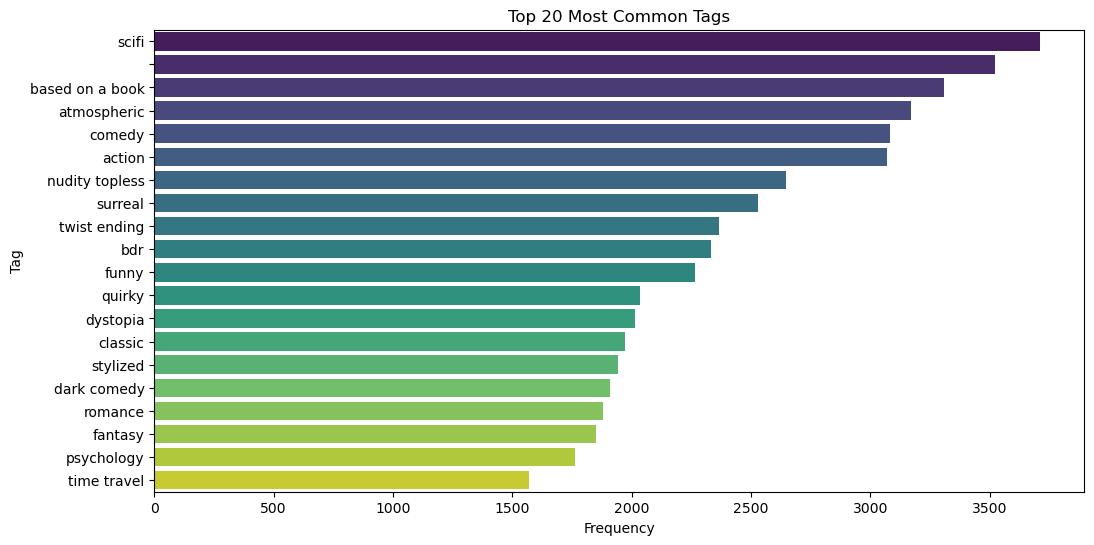

In [9]:
# Count the frequency of each cleaned tag
tag_counts = tags['cleaned_tag'].value_counts()

# Display the top 20 most common tags
print(tag_counts.head(20))

# Plot the top 20 most common tags
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.head(20).values, y=tag_counts.head(20).index, palette='viridis')
plt.title('Top 20 Most Common Tags')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.show()

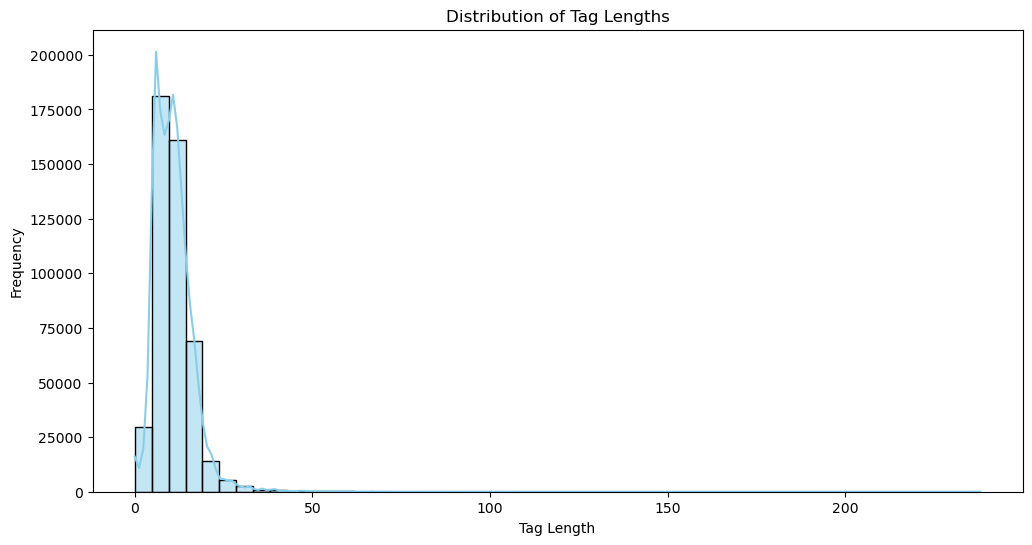

In [10]:
# Calculate the length of each cleaned tag
tags['tag_length'] = tags['cleaned_tag'].apply(len)

# Display the distribution of tag lengths
plt.figure(figsize=(12, 6))
sns.histplot(tags['tag_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Tag Lengths')
plt.xlabel('Tag Length')
plt.ylabel('Frequency')
plt.show()

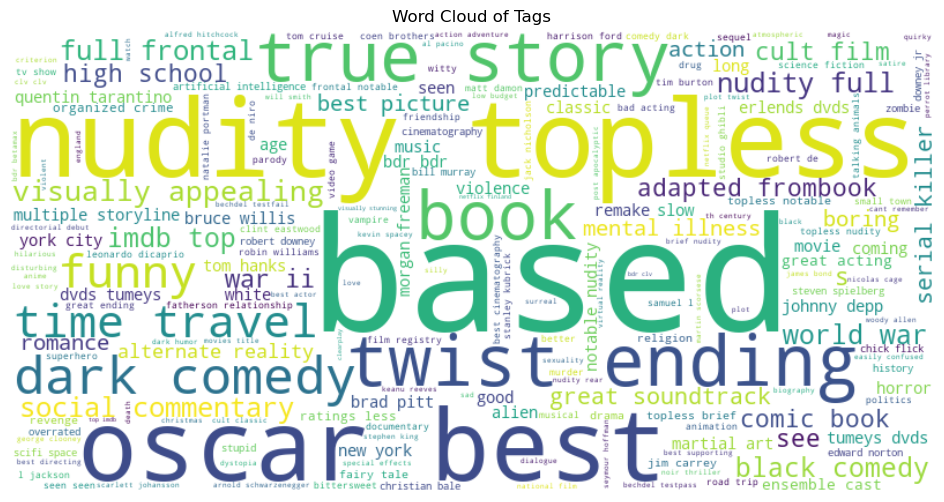

In [12]:
from wordcloud import WordCloud

# Combine all cleaned tags into a single string
all_tags = ' '.join(tags['cleaned_tag'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags')
plt.show()

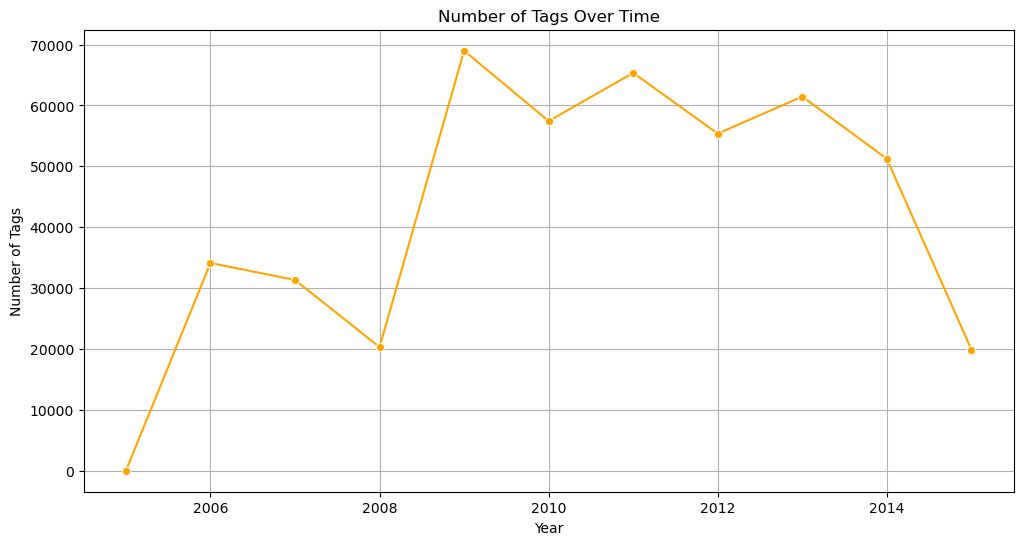

In [13]:
# Convert the timestamp to a more readable format
tags['year'] = tags['timestamp'].dt.year

# Count the number of tags per year
tags_per_year = tags['year'].value_counts().sort_index()

# Plot the number of tags per year
plt.figure(figsize=(12, 6))
sns.lineplot(x=tags_per_year.index, y=tags_per_year.values, marker='o', color='orange')
plt.title('Number of Tags Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Tags')
plt.grid(True)
plt.show()

userId
88738     20356
70201     13541
130827    10642
58612      9497
123297     8369
124998     7272
1741       6404
11081      5850
120937     5571
10616      4963
52814      4585
27898      4193
68558      4051
25737      3675
77463      3668
4450       3215
9815       3048
57434      2795
119367     2792
28906      2792
Name: count, dtype: int64


/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_92694/2697931800.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags_per_user.head(20).values, y=tags_per_user.head(20).index, palette='plasma')


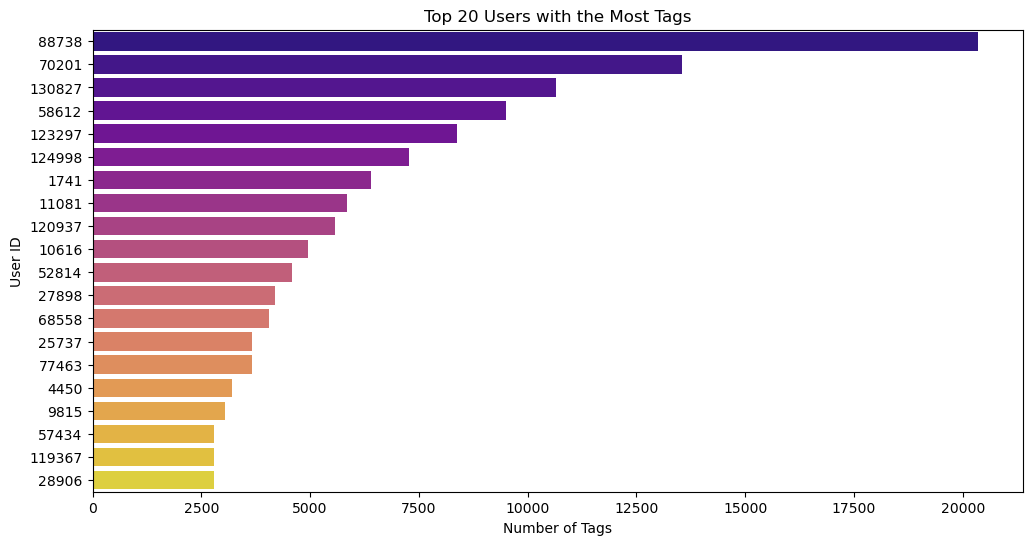

In [14]:
# Count the number of tags per user
tags_per_user = tags['userId'].value_counts()

# Display the top 20 users with the most tags
print(tags_per_user.head(20))

# Plot the top 20 users with the most tags
plt.figure(figsize=(12, 6))
sns.barplot(x=tags_per_user.head(20).values, y=tags_per_user.head(20).index, palette='plasma')
plt.title('Top 20 Users with the Most Tags')
plt.xlabel('Number of Tags')
plt.ylabel('User ID')
plt.show()

movieId
296      1994
2959     1779
79132    1552
2571     1430
318      1339
7361     1240
4878     1177
4226     1168
593      1100
72998     995
356       991
47        975
541       969
58559     963
44191     946
4973      922
32587     907
32        899
50        891
48780     880
Name: count, dtype: int64


/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_92694/2202418749.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags_per_movie.head(20).values, y=tags_per_movie.head(20).index, palette='magma')


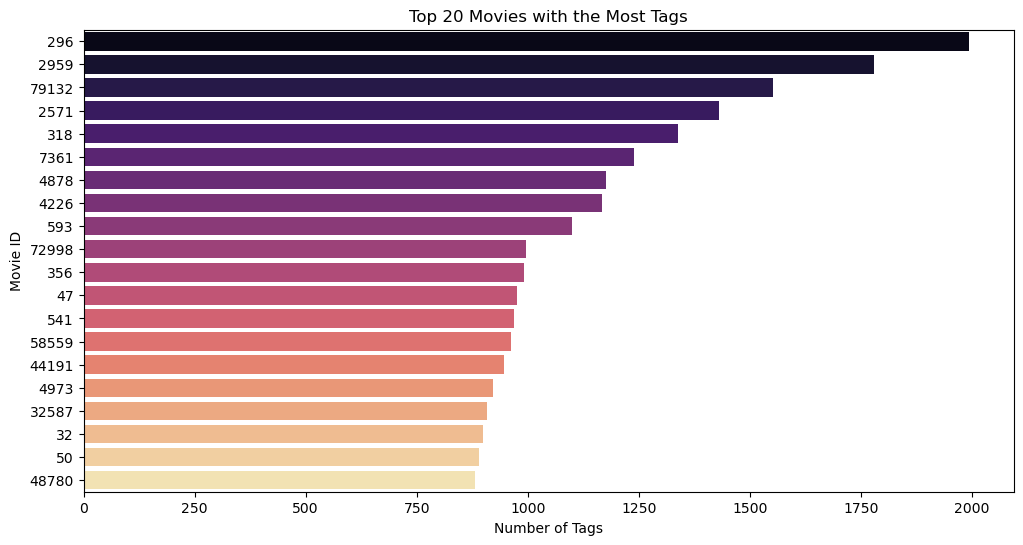

In [15]:
# Count the number of tags per movie
tags_per_movie = tags['movieId'].value_counts()

# Display the top 20 movies with the most tags
print(tags_per_movie.head(20))

# Plot the top 20 movies with the most tags
plt.figure(figsize=(12, 6))
sns.barplot(x=tags_per_movie.head(20).values, y=tags_per_movie.head(20).index, palette='magma')
plt.title('Top 20 Movies with the Most Tags')
plt.xlabel('Number of Tags')
plt.ylabel('Movie ID')
plt.show()